In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class FourierEncoding(nn.Module):
  def __init__(self, num_frequencies):
    super().__init__()
    self.num_frequencies = num_frequencies
    # Frequencies: 2^0, 2^1, ..., 2^(L-1)
    self.frequencies = 2**torch.arange(num_frequencies, dtype=torch.float32)
    self.frequencies = self.frequencies * torch.pi # Scale by Pi

  def forward(self, x):
    #reshape inputs and frequencies
    x_expanded = x.unsqueeze(-1)
    freq_expanded = self.frequencies.view(1,1,-1)
    args = x_expanded * freq_expanded
    args = args.view(x.shape[0],-1)
    return torch.cat([x, torch.sin(args), torch.cos(args)], dim=-1)

In [11]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, hidden_layers, output_size,num_frequencies):
    super().__init__()
    self.embedding = FourierEncoding(num_frequencies=10)
    input_dim = input_size + 2 * num_frequencies * input_size
    layers=[]
    layers.append(nn.Linear(input_dim, hidden_size))
    layers.append(nn.ReLU())
    for _ in range(hidden_layers):
      layers.append(nn.Linear(hidden_size, hidden_size))
      layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_size, output_size))
    layers.append(nn.Sigmoid())
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    x_embedded = self.embedding(x)
    return self.model(x_embedded)


In [27]:
IMAGE_PATH = 'target.jpeg'
IMG_SIZE = 128
BATCH_SIZE = 1024
EPOCHS = 1200
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
def get_image_tensor(path, size):
    img = Image.open(path).convert('RGB')
    img = img.resize((size, size))
    img_tensor = torch.from_numpy(np.array(img)).float() / 255.0
    return img_tensor

#normalized to [-1, 1]
def get_coordinates(size):

    x = torch.linspace(-1, 1, size)
    y = torch.linspace(-1, 1, size)

    # Generate grid: meshgrid 'ij' indexing puts y first (rows), x second (cols)
    grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')

    # Stack for(size, size, 2)
    coords = torch.stack([grid_x, grid_y], dim=-1)
    return coords.reshape(-1, 2) # Flatten

In [29]:
def train():
    try:
        target_img = get_image_tensor(IMAGE_PATH, IMG_SIZE).to(DEVICE)
    except FileNotFoundError:
        print(f"Error: '{IMAGE_PATH}' not found. Please add an image file.")
        return

    #Flatten
    target_pixels = target_img.view(-1, 3)

    #Get coordinates
    coords = get_coordinates(IMG_SIZE).to(DEVICE)

    #Initialize Model
    model = MLP(input_size=2, hidden_size=256, hidden_layers=3, output_size=3, num_frequencies=10).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    print(f"Training on {DEVICE}...")

    for epoch in range(EPOCHS):
        #Randomly sample indices for batching
        idx = torch.randperm(coords.shape[0])[:BATCH_SIZE]
        batch_coords = coords[idx]
        batch_targets = target_pixels[idx]

        #forward pass
        optimizer.zero_grad()
        outputs = model(batch_coords)
        loss = criterion(outputs, batch_targets)

        #backward pass
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            psnr = -10 * torch.log10(loss)
            print(f"Epoch {epoch}, Loss: {loss.item():.5f}, PSNR: {psnr.item():.2f} dB")
    #Reconstruction
    print("Reconstructing full image...")
    with torch.no_grad():
        #Predict all pixels
        #128x128
        reconstructed_pixels = model(coords)
        reconstructed_img = reconstructed_pixels.view(IMG_SIZE, IMG_SIZE, 3).cpu().numpy()

    #Viz
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Target")
    plt.imshow(target_img.cpu().numpy())
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Neural Reconstruction\n(Epoch {EPOCHS})")
    plt.imshow(reconstructed_img)
    plt.axis('off')
    plt.show()
    return model

Training on cpu...
Epoch 0, Loss: 0.12183, PSNR: 9.14 dB
Epoch 100, Loss: 0.00531, PSNR: 22.75 dB
Epoch 200, Loss: 0.00196, PSNR: 27.09 dB
Epoch 300, Loss: 0.00107, PSNR: 29.71 dB
Epoch 400, Loss: 0.00079, PSNR: 31.05 dB
Epoch 500, Loss: 0.00050, PSNR: 33.00 dB
Epoch 600, Loss: 0.00040, PSNR: 33.98 dB
Epoch 700, Loss: 0.00036, PSNR: 34.41 dB
Epoch 800, Loss: 0.00027, PSNR: 35.73 dB
Epoch 900, Loss: 0.00023, PSNR: 36.33 dB
Epoch 1000, Loss: 0.00023, PSNR: 36.37 dB
Epoch 1100, Loss: 0.00017, PSNR: 37.64 dB
Reconstructing full image...


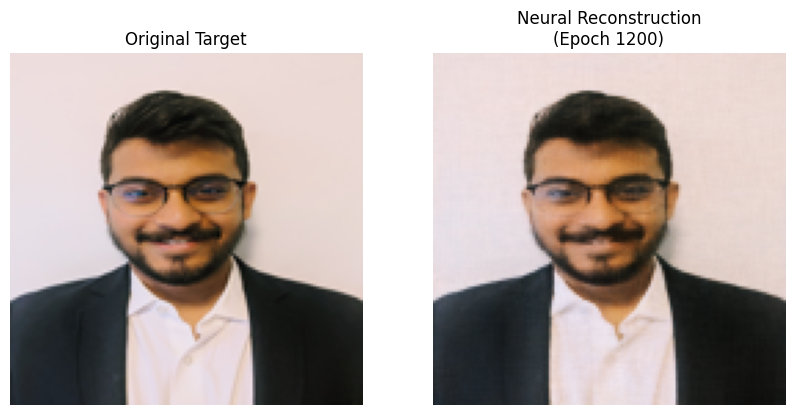

In [31]:
model=train()